# NicheCompass

### 1. Trying the integration method for NicheCompass

Check the documentation for NicheCompass installation instructions.

The data for this tutorial can be downloaded from Google Drive. It has to be stored under <repository_root>/data/spatial_omics/starmap_plus_mouse_cns_batch1.h5ad

A pretrained model to run only the analysis can be downloaded from Google Drive. It has to be stored under <repository_root>/artifacts/single_sample/<timestamp>/model/09022024_180928

### 1.1 Importing libraries

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
import random
import warnings
from datetime import datetime
import gdown

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                create_new_color_dict,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)

### 1.2 Define the parameters

We change here some of the labels, following the code output by Jonathan. 

In [19]:
### Dataset ###
#Here the dataset Jonathan uses is cellxgene_test (just a title), but using P67, 47, 46, 82 .... ? Where are we suppose to give the paths for these files ???? 
dataset = "Lung_sample"
species = "human"
batches = ["lung_L1_1", "lung_L2_2", "lung_L2_2_rep", "lung_L3_1", "lung_L4_1"]
spatial_key = "spatial"
n_neighbors = 4

### Model ###
# AnnData keys
counts_key = "counts"
adj_key = "spatial_connectivities"
#Here Jonathan also set the  key to donor_id
cat_covariates_keys = ["batch"]
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
cat_covariates_embeds_injection = ["gene_expr_decoder"] 

cat_covariates_embeds_nums = [3]
cat_covariates_no_edges = [True]
conv_layer_encoder = "gcnconv"
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # increase if gene selection desired
lambda_l1_addon = 100.
edge_batch_size = 1024 # increase if more memory available
n_sampled_neighbors = 4
use_cuda_if_available = True

### Analysis ###
cell_type_key = "cell_type"
latent_leiden_resolution = 0.2
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
#He set the sample keys to donor_id
sample_key = "batch"
spot_size = 0.2
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

### 1.3 Run Notebook Setup

In [20]:
warnings.filterwarnings("ignore")

In [21]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths 

In [22]:
import os

current_path = os.getcwd()
print("Current path:", current_path)

Current path: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Analysis/NicheCompass


In [23]:
# Define paths
ga_data_folder_path = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Analysis/NicheCompass/data/gene_annotations"
gp_data_folder_path = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Analysis/NicheCompass/data/gene_programs"
so_data_folder_path = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Analysis/NicheCompass/data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Analysis/NicheCompass/artifacts"
model_folder_path = f"{artifacts_folder_path}/sample_integration/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/sample_integration/{current_timestamp}/figures"

### 1.5 Create Directories

In [24]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(so_data_folder_path, exist_ok=True)

### 1.6 Getting the files (or using your own files) 

This downloads the h5ad files used in the vignette. We should try replacing them with the files along the following path : 





In [16]:
#gdown.download('https://drive.google.com/uc?id=1MOjIyue7a-JDAcnAseqIljDyoO7KtH99', so_data_folder_path+'/starmap_plus_mouse_cns_batch1.h5ad')
#gdown.download('https://drive.google.com/uc?id=1_RcLVuZcJiFw-iaB7saPX4ydR1X2CvaS', so_data_folder_path+'/starmap_plus_mouse_cns_batch2.h5ad')
#gdown.download('https://drive.google.com/uc?id=1sIIHGZ55aYBbgCXCBvIrGxB7i7OgUuJ9', so_data_folder_path+'/starmap_plus_mouse_cns_batch3.h5ad')

## 2. Prepare Model Training

### 2.1 Create Prior Knowledge Gene Program (GP) Mask

As a default, here we create a GP mask based on three databases of prior knowledge of inter- and intracellular interaction pathways:
- OmniPath (Ligand-Receptor GPs)
- MEBOCOST (Enzyme-Sensor GPs)
- NicheNet (Combined Interaction GPs)

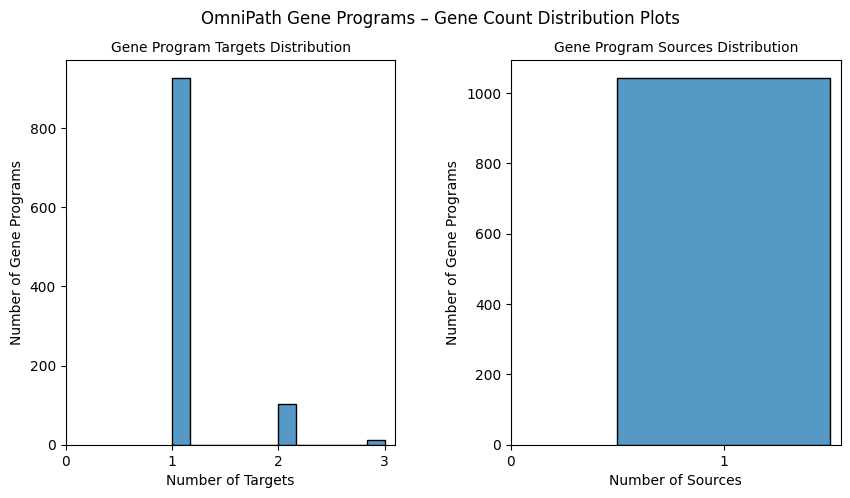

In [25]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
                                           "/omnipath_gp_gene_count_distributions.svg")

In [26]:
# Display example OmniPath GP
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

HLA-DRB5_ligand_receptor_GP: {'sources': ['HLA-DRB5'], 'targets': ['CD4'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


In [27]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

FileNotFoundError: [Errno 2] No such file or directory: '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/Analysis/NicheCompass/data/gene_programs/metabolite_enzyme_sensor_gps/human_metabolite_enzymes.tsv'

In [11]:
# Display example MEBOCOST GP
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

NameError: name 'mebocost_gp_dict' is not defined